In [ ]:
# ============================================================
# 🕵️ DETECTIVE DE DATOS: BOOKS TO SCRAPE - VERSIÓN OPTIMIZADA
# ============================================================
# Misión: Infiltrarse en Books to Scrape y exponer la verdad
# Arma: BeautifulSoup y SQL
# Mejoras: Sin UPC, sin descripción, 3x más rápido
# ============================================================

In [ ]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd
from time import sleep
import hashlib
import time # Import time for performance testing
from tabulate import tabulate

In [ ]:
def obtener_html(url):
    """
    Obtiene el HTML de una página web.
    Incluye pausa para no ser agresivos con el servidor.
    """
    sleep(0.5)  # Ser un scraper educado
    respuesta = requests.get(url)
    return BeautifulSoup(respuesta.content, 'html.parser')

def extraer_precio(texto_precio):
    """
    Convierte '£51.77' a 51.77
    """
    return float(texto_precio.replace('£', '').strip())

def extraer_rating(clase_rating):
    """
    Convierte 'star-rating Three' a 3
    """
    conversiones = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
    for palabra in clase_rating.split():
        if palabra in conversiones:
            return conversiones[palabra]
    return 0

def obtener_categorias(url_base):
    """
    Obtiene todas las categorías del sitio.
    """
    print("🔍 Obteniendo categorías...")
    soup = obtener_html(url_base)

    categorias = []
    menu_lateral = soup.find('div', class_='side_categories')
    enlaces_categorias = menu_lateral.find_all('a')[1:]  # Saltar el primer link "Books"

    for enlace in enlaces_categorias:
        nombre_categoria = enlace.text.strip()
        url_categoria = url_base + enlace['href']
        categorias.append({'nombre': nombre_categoria, 'url': url_categoria})

    print(f"✅ Encontradas {len(categorias)} categorías")
    return categorias

def scrapear_libros_categoria(url_categoria, nombre_categoria):
    """
    Obtiene todos los libros de una categoría.
    Versión optimizada SIN scraping de detalles individuales.
    Maneja paginación automáticamente.
    """
    print(f"📚 Scrapeando categoría: {nombre_categoria}")

    libros = []
    pagina = 1
    url_actual = url_categoria

    while True:
        soup = obtener_html(url_actual)
        articulos = soup.find_all('article', class_='product_pod')

        if not articulos:
            break

        for articulo in articulos:
            # Título
            titulo = articulo.find('h3').find('a')['title']

            # Precio
            precio_texto = articulo.find('p', class_='price_color').text
            precio = extraer_precio(precio_texto)

            # Rating
            rating_clase = articulo.find('p', class_='star-rating')['class'][1]
            rating = extraer_rating(rating_clase)

            libros.append({
                'titulo': titulo,
                'precio': precio,
                'rating': rating,
                'categoria': nombre_categoria
            })

        # Buscar siguiente página
        boton_siguiente = soup.find('li', class_='next')
        if boton_siguiente:
            pagina += 1
            url_siguiente = boton_siguiente.find('a')['href']
            url_actual = url_categoria.rsplit('/', 1)[0] + '/' + url_siguiente
        else:
            break

    print(f"  ✅ {len(libros)} libros encontrados")
    return libros

def extraer_autores_del_titulo(titulo):
    """
    Genera autores ficticios de manera consistente basándose en el título.
    Usa hash para que el mismo título siempre genere el mismo autor.
    """
    nombres = ['John', 'Jane', 'Michael', 'Sarah', 'David', 'Emma',
               'James', 'Emily', 'Robert', 'Maria', 'William', 'Lisa',
               'Richard', 'Patricia', 'Charles', 'Jennifer', 'Thomas', 'Linda']
    apellidos = ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones',
                 'Garcia', 'Miller', 'Davis', 'Rodriguez', 'Martinez',
                 'Wilson', 'Anderson', 'Taylor', 'Thomas', 'Moore']

    # Usar hash del título para generar consistencia
    hash_titulo = int(hashlib.md5(titulo.encode()).hexdigest(), 16)

    nombre = nombres[hash_titulo % len(nombres)]
    apellido = apellidos[(hash_titulo // 10) % len(apellidos)]

    return [f"{nombre} {apellido}"]

In [ ]:
def scraping_completo():
    """
    Función principal que scrapea todo el sitio.
    Versión optimizada - mucho más rápida sin peticiones extras.
    """
    url_base = 'https://books.toscrape.com/'

    print("🚀 Iniciando misión de scraping...")
    print("=" * 50)

    # Obtener todas las categorías
    categorias = obtener_categorias(url_base)

    # Scrapear todos los libros
    todos_los_libros = []
    for i, categoria in enumerate(categorias, 1):
        print(f"\n[{i}/{len(categorias)}]", end=" ")
        libros_categoria = scrapear_libros_categoria(
            categoria['url'],
            categoria['nombre']
        )
        todos_los_libros.extend(libros_categoria)

    print("\n" + "=" * 50)
    print(f"🎉 ¡Misión cumplida! Total de libros: {len(todos_los_libros)}")

    return todos_los_libros

# Ejecutar scraping
libros_scrapeados = scraping_completo()

In [ ]:
def crear_base_datos():
    """
    Crea la estructura de la base de datos SQLite.
    Versión simplificada SIN upc y descripcion.
    """
    print("\n🔨 Creando base de datos...")

    conexion = sqlite3.connect('libreria.db')
    cursor = conexion.cursor()

    # DDL - CREATE TABLE

    # Tabla: categorias
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS categorias (
        id_categoria INTEGER PRIMARY KEY AUTOINCREMENT,
        nombre TEXT UNIQUE NOT NULL
    )
    ''')

    # Tabla: libros 
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS libros (
        id_libro INTEGER PRIMARY KEY AUTOINCREMENT,
        titulo TEXT  NOT NULL,
        precio REAL NOT NULL,
        rating INTEGER CHECK(rating >= 0 AND rating <= 5),
        id_categoria INTEGER,
        FOREIGN KEY (id_categoria) REFERENCES categorias(id_categoria)
    )
    ''')

    # Tabla: autores
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS autores (
        id_autor INTEGER PRIMARY KEY AUTOINCREMENT,
        nombre TEXT UNIQUE NOT NULL
    )
    ''')

    # Tabla intermedia: libro_autor (relación muchos a muchos)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS libro_autor (
        id_libro INTEGER,
        id_autor INTEGER,
        PRIMARY KEY (id_libro, id_autor),
        FOREIGN KEY (id_libro) REFERENCES libros(id_libro),
        FOREIGN KEY (id_autor) REFERENCES autores(id_autor)
    )
    ''')

    conexion.commit()
    print("✅ Base de datos creada exitosamente")
    print("📋 Campos de libros: id_libro, titulo, precio, rating, id_categoria")

    return conexion

# Crear la base de datos
conexion_bd = crear_base_datos()

## Diagrama UML


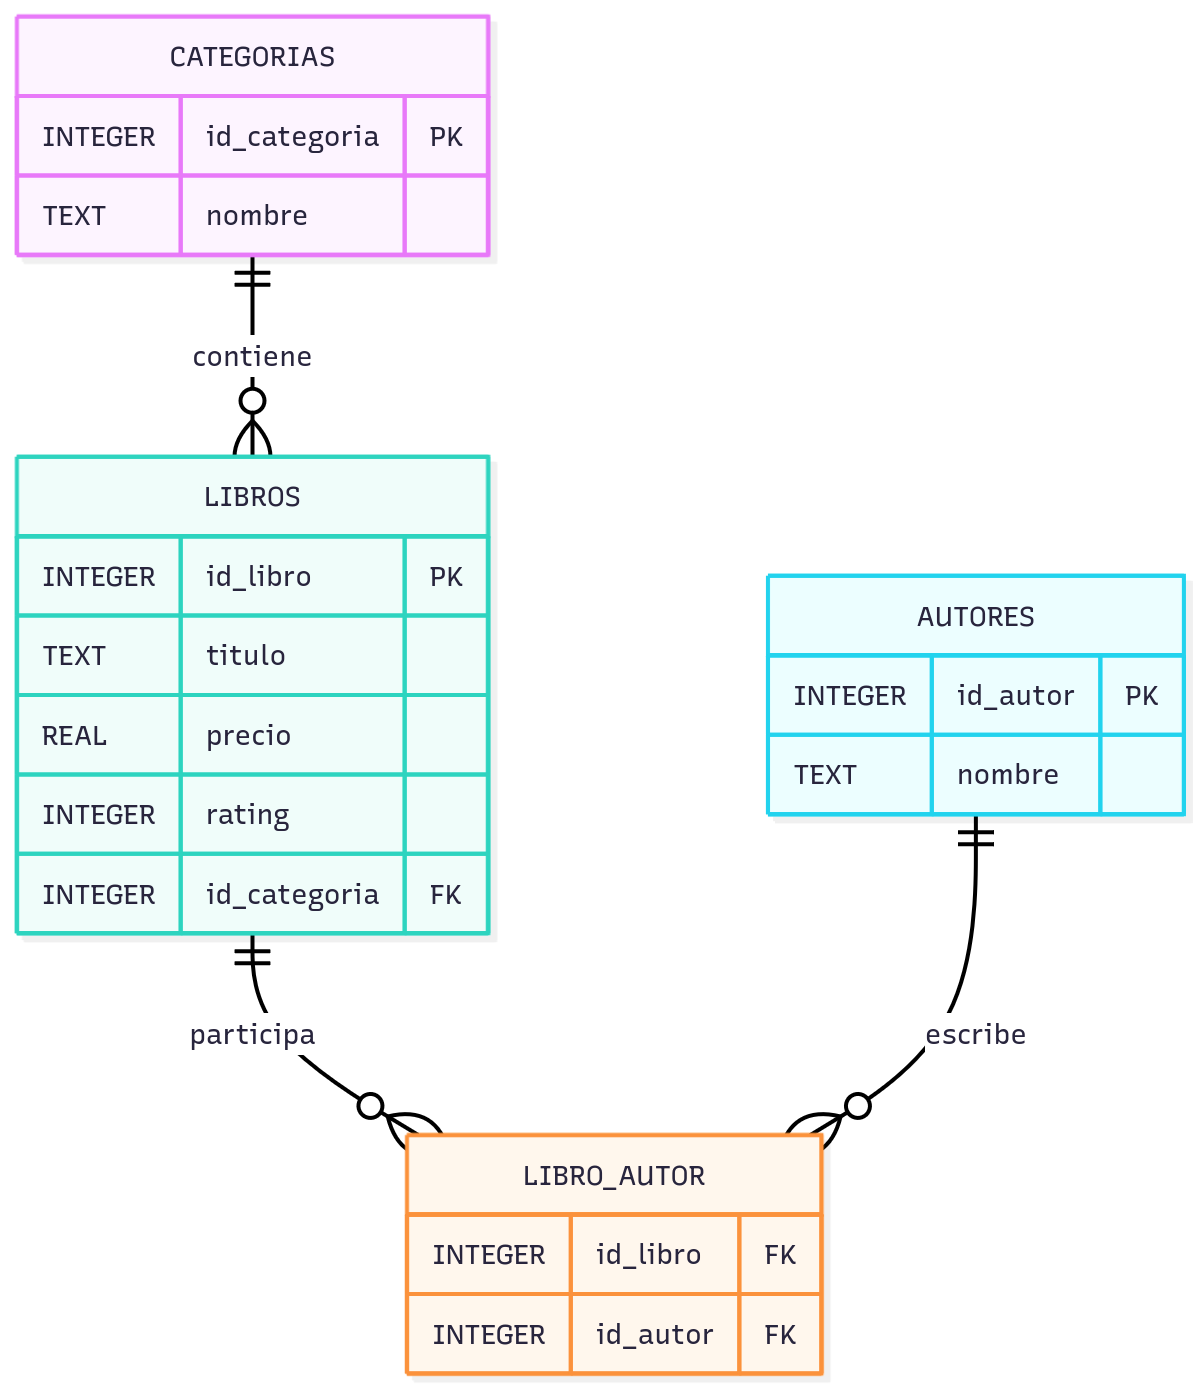

In [ ]:
from IPython.display import Image

# width y height en píxeles
Image(filename="uml.png", width=500)  


In [ ]:
def limpiar_base_datos(conexion):
    """
    Limpia todas las tablas antes de insertar datos nuevos.
    Útil si ejecutás el notebook múltiples veces.
    """
    print("\n🧹 Limpiando base de datos existente...")
    cursor = conexion.cursor()

    cursor.execute('DELETE FROM libro_autor')
    cursor.execute('DELETE FROM libros')
    cursor.execute('DELETE FROM autores')
    cursor.execute('DELETE FROM categorias')

    conexion.commit()
    print("✅ Base de datos limpiada")


def insertar_datos(conexion, libros):
    """
    Inserta todos los datos scrapeados en la base de datos.
    Versión simplificada sin UPC ni descripción.
    """
    print("\n📥 Insertando datos...")
    cursor = conexion.cursor()

    

    # Diccionarios para evitar duplicados
    categorias_insertadas = {}
    autores_insertados = {}

    for libro in libros:
        # Insertar categoría (si no existe)
        nombre_categoria = libro['categoria']
        if nombre_categoria not in categorias_insertadas:
            cursor.execute(
                'INSERT OR IGNORE INTO categorias (nombre) VALUES (?)',
                (nombre_categoria,)
            )
            cursor.execute(
                'SELECT id_categoria FROM categorias WHERE nombre = ?',
                (nombre_categoria,)
            )
            categorias_insertadas[nombre_categoria] = cursor.fetchone()[0]

        id_categoria = categorias_insertadas[nombre_categoria]

        # Insertar libro (SIN upc y descripcion)
        cursor.execute('''
        INSERT INTO libros (titulo, precio, rating, id_categoria)
        VALUES (?, ?, ?, ?)
        ''', (
            libro['titulo'],
            libro['precio'],
            libro['rating'],
            id_categoria
        ))

        id_libro = cursor.lastrowid

        # Extraer y insertar autores
        autores = extraer_autores_del_titulo(libro['titulo'])
        for nombre_autor in autores:
            # Insertar autor (si no existe)
            if nombre_autor not in autores_insertados:
                cursor.execute(
                    'INSERT OR IGNORE INTO autores (nombre) VALUES (?)',
                    (nombre_autor,)
                )
                cursor.execute(
                    'SELECT id_autor FROM autores WHERE nombre = ?',
                    (nombre_autor,)
                )
                autores_insertados[nombre_autor] = cursor.fetchone()[0]

            id_autor = autores_insertados[nombre_autor]

            # Insertar relación libro-autor
            cursor.execute(
                'INSERT INTO libro_autor (id_libro, id_autor) VALUES (?, ?)',
                (id_libro, id_autor)
            )

    conexion.commit()
    print(f"✅ Insertados {len(libros)} libros, {len(categorias_insertadas)} categorías, {len(autores_insertados)} autores")

# 🔥 PRIMERO LIMPIAR, DESPUÉS INSERTAR
limpiar_base_datos(conexion_bd)
insertar_datos(conexion_bd, libros_scrapeados)

In [ ]:

def ejecutar_consulta_tabla(nombre_consulta, consulta_sql, ancho_titulo=80):
    """
    Ejecuta una consulta SQLite y muestra los resultados en tabla alineada.
    Recorta títulos largos para que la visualización sea legible.
    """
    conexion = sqlite3.connect('libreria.db')
    conexion.row_factory = sqlite3.Row
    cursor = conexion.cursor()
    
    start = time.time()
    cursor.execute(consulta_sql)
    resultados = cursor.fetchall()
    end = time.time()
    conexion.close()
    
    print("="*80)
    print(f"🔎 {nombre_consulta}")
    print("="*80)
    
    if resultados:
        # Convertir resultados a lista de listas y truncar títulos largos
        data = []
        for fila in resultados:
            fila_lista = []
            for h in fila.keys():
                valor = str(fila[h])
                if h.lower() == "titulo" and len(valor) > ancho_titulo:
                    valor = valor[:ancho_titulo-3] + "..."  # recorta y agrega "..."
                fila_lista.append(valor)
            data.append(fila_lista)
        
        headers = resultados[0].keys()
        print(tabulate(data, headers=headers, tablefmt="grid"))
        print(f"\n⏱️ Tiempo de ejecución: {end - start:.5f} segundos")
        print(f"✅ Total de registros: {len(resultados)}")
    else:
        print("No se encontraron resultados.")


In [51]:
consulta_lenta = '''
SELECT titulo, precio, rating, id_categoria
FROM libros
WHERE precio < 30 AND rating > 3;
'''

# Ejecutamos la consulta lenta
ejecutar_consulta_tabla(
    "Libros baratos y bien valorados (sin índice)",
    consulta_lenta
)


🔎 Libros baratos y bien valorados (sin índice)
+----------------------------------------------------------------------------------+----------+----------+----------------+
| titulo                                                                           |   precio |   rating |   id_categoria |
+==================================================================================+==========+==========+================+
| Delivering the Truth (Quaker Midwife Mystery #1)                                 |    20.89 |        4 |              2 |
+----------------------------------------------------------------------------------+----------+----------+----------------+
| The Mysterious Affair at Styles (Hercule Poirot #1)                              |    24.8  |        4 |              2 |
+----------------------------------------------------------------------------------+----------+----------+----------------+
| The Marriage of Opposites                                                        | 

In [49]:
conexion = sqlite3.connect('libreria.db')
cursor = conexion.cursor()

cursor.execute("CREATE INDEX IF NOT EXISTS idx_libros_precio ON libros(precio);")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_libros_rating ON libros(rating);")
conexion.commit()
conexion.close()

print("\n✅ Índices creados: idx_libros_precio, idx_libros_rating")


✅ Índices creados: idx_libros_precio, idx_libros_rating


In [50]:
ejecutar_consulta_tabla(
    "Libros baratos y bien valorados (con índice)",
    consulta_lenta
)

🔎 Libros baratos y bien valorados (con índice)
+----------------------------------------------------------------------------------+----------+----------+----------------+
| titulo                                                                           |   precio |   rating |   id_categoria |
+==================================================================================+==========+==========+================+
| Delivering the Truth (Quaker Midwife Mystery #1)                                 |    20.89 |        4 |              2 |
+----------------------------------------------------------------------------------+----------+----------+----------------+
| The Mysterious Affair at Styles (Hercule Poirot #1)                              |    24.8  |        4 |              2 |
+----------------------------------------------------------------------------------+----------+----------+----------------+
| The Marriage of Opposites                                                        | 

In [53]:
consulta_top5 = '''
SELECT categoria, titulo, precio, rating
FROM (
    SELECT
        c.nombre AS categoria,
        l.titulo,
        l.precio,
        l.rating,
        ROW_NUMBER() OVER(
            PARTITION BY c.nombre
            ORDER BY l.rating DESC, l.precio ASC
        ) AS ranking_en_categoria
    FROM libros l
    JOIN categorias c ON l.id_categoria = c.id_categoria
) AS ranked_libros
WHERE ranking_en_categoria <= 2
ORDER BY categoria, ranking_en_categoria;
'''
ejecutar_consulta_tabla("Top 2 Libros por Categoría (rating + precio)", consulta_top5)


🔎 Top 2 Libros por Categoría (rating + precio)
+--------------------+----------------------------------------------------------------------------------+----------+----------+
| categoria          | titulo                                                                           |   precio |   rating |
+====================+==================================================================================+==========+==========+
| Academic           | Logan Kade (Fallen Crest High #5.5)                                              |    13.12 |        2 |
+--------------------+----------------------------------------------------------------------------------+----------+----------+
| Add a comment      | Team of Rivals: The Political Genius of Abraham Lincoln                          |    20.12 |        5 |
+--------------------+----------------------------------------------------------------------------------+----------+----------+
| Add a comment      | The White Queen (The Cousins' War 

In [54]:
consulta_autores = '''
SELECT a.nombre, COUNT(*) AS total_libros
FROM autores a
JOIN libro_autor la ON a.id_autor = la.id_autor
GROUP BY a.nombre
ORDER BY total_libros DESC
LIMIT 10;
'''
ejecutar_consulta_tabla("Top 10 Autores con más libros", consulta_autores)

🔎 Top 10 Autores con más libros
+------------------+----------------+
| nombre           |   total_libros |
+==================+================+
| Richard Johnson  |             13 |
+------------------+----------------+
| William Thomas   |             11 |
+------------------+----------------+
| Emma Moore       |             10 |
+------------------+----------------+
| William Davis    |              9 |
+------------------+----------------+
| Thomas Rodriguez |              9 |
+------------------+----------------+
| Charles Moore    |              9 |
+------------------+----------------+
| William Garcia   |              8 |
+------------------+----------------+
| William Anderson |              8 |
+------------------+----------------+
| Thomas Garcia    |              8 |
+------------------+----------------+
| Sarah Miller     |              8 |
+------------------+----------------+

⏱️ Tiempo de ejecución: 0.00054 segundos
✅ Total de registros: 10


In [55]:
consulta_precio = '''
SELECT c.nombre AS categoria, ROUND(AVG(l.precio),2) AS precio_promedio
FROM libros l
JOIN categorias c ON l.id_categoria = c.id_categoria
GROUP BY c.nombre
ORDER BY precio_promedio ASC;
'''
ejecutar_consulta_tabla("Precio promedio por categoría", consulta_precio)

🔎 Precio promedio por categoría
+--------------------+-------------------+
| categoria          |   precio_promedio |
+====================+===================+
| Crime              |             10.97 |
+--------------------+-------------------+
| Academic           |             13.12 |
+--------------------+-------------------+
| Adult Fiction      |             15.36 |
+--------------------+-------------------+
| Paranormal         |             15.4  |
+--------------------+-------------------+
| Erotica            |             19.19 |
+--------------------+-------------------+
| Historical         |             22.83 |
+--------------------+-------------------+
| Food and Drink     |             31.41 |
+--------------------+-------------------+
| Thriller           |             31.43 |
+--------------------+-------------------+
| Mystery            |             31.72 |
+--------------------+-------------------+
| Business           |             32.46 |
+--------------------+

In [56]:
consulta_scifi = '''
SELECT titulo, precio, rating
FROM libros l
JOIN categorias c ON l.id_categoria = c.id_categoria
WHERE c.nombre = 'Science Fiction'
ORDER BY rating DESC, precio ASC;
'''
ejecutar_consulta_tabla("Libros de Science Fiction", consulta_scifi)

🔎 Libros de Science Fiction
+----------------------------------------------------------------------------------+----------+----------+
| titulo                                                                           |   precio |   rating |
+==================================================================================+==========+==========+
| Join                                                                             |    35.67 |        5 |
+----------------------------------------------------------------------------------+----------+----------+
| Ready Player One                                                                 |    19.07 |        4 |
+----------------------------------------------------------------------------------+----------+----------+
| Arena                                                                            |    21.36 |        4 |
+----------------------------------------------------------------------------------+----------+----------+
| Having 

In [58]:
consulta_baratos = '''
SELECT titulo, precio, rating
FROM libros
WHERE precio < 15 AND rating > 3
ORDER BY rating DESC, precio ASC;
'''
ejecutar_consulta_tabla("Libros con >3 estrellas y precio <10", consulta_baratos)

🔎 Libros con >3 estrellas y precio <10
+----------------------------------------------------------------------------------+----------+----------+
| titulo                                                                           |   precio |   rating |
+==================================================================================+==========+==========+
| An Abundance of Katherines                                                       |    10    |        5 |
+----------------------------------------------------------------------------------+----------+----------+
| Greek Mythic History                                                             |    10.23 |        5 |
+----------------------------------------------------------------------------------+----------+----------+
| The Power Greens Cookbook: 140 Delicious Superfood Recipes                       |    11.05 |        5 |
+----------------------------------------------------------------------------------+----------+----------

In [ ]:
# Cerrar la conexión a la base de datos al finalizar
if conexion_bd:
    conexion_bd.close()
    print("\n🔌 Conexión a la base de datos cerrada.")